This notebook explores the Online Retail II Data Set stored on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail+II).

In [119]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

The dataset can be obtained from this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx).
Save it in the datasets directory.

In [25]:
file = '../../datasets/online_retail_II.xlsx'

In [203]:
# The data is provided as two sheets in a single Excel file.
# Each sheet contains a different time period.
# Load both and join into a single dataframe.
df_1 = pd.read_excel(file, sheet_name='Year 2009-2010')
df_2 = pd.read_excel(file, sheet_name='Year 2010-2011')
df = pd.concat([df_1, df_2])

In [204]:
# Inspect dataframe
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [207]:
# Rename columns
df.columns = ['invoice', 
              'stock_code',
              'description',
              'quantity',
              'invoice_date',
              'price',
              'customer_id',
              'country']

# Process data

Remove null customer ids

In [386]:
mask = ~df['customer_id'].isnull()
df = df[mask]

Create a flag for when an order is cancelled. Cancelled orders contain 
the letter `C` at the start of the invoice.

In [345]:
 df['is_cancelled'] = df['invoice'].apply(lambda x: str(x)[0] is 'C')

Remove transactions which are negative quantities sold and are not cancelled orders

In [389]:
mask = (~(~df['is_cancelled'] & df['quantity']<0)) 
df = df[mask]

Compute revenue

In [390]:
df['revenue'] = df['quantity'] * df['price']

To compute gross revenue and quantity sold we filter out cancelled orders.

After this we resample the data at a weekly level.

In [403]:
mask = (~df['is_cancelled']) 
df_gross = (
    df.loc[mask, ['invoice_date', 'quantity', 'revenue', 'country']]
    .groupby('country')
    .resample('W', on='invoice_date')
    .sum()
)

We now compute net revenue and quantity sold at a weekly level.

In [404]:
df_net = (
    df.loc[mask, ['invoice_date', 'quantity', 'revenue', 'country']]
    .groupby('country')
    .resample('W', on='invoice_date')
    .sum()
)

# Save data

In [473]:
y = df_gross.unstack('country')['revenue']['United Kingdom'].to_frame()

In [474]:
y

,United Kingdom
invoice_date,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00
...,...
2011-11-13,229378.01
2011-11-20,221870.29
2011-11-27,210741.76


In [520]:
def add_year(df):
    df['year'] = df.index.year
    return df

def add_week_of_year(df):
    df['week_of_year'] = df.index.weekofyear
    return df

def add_time_since_start(df):
    df['time_since_start'] = (df.index - df.index[0])
    df['time_since_start'] = df['time_since_start'].dt.days
    return df

In [521]:
y = add_year(y)
y = add_week_of_year(y)
y = add_time_since_start(y)

In [628]:
X = y[['time_since_start', 'week_of_year', 'year']].values

In [629]:
Y = y['United Kingdom'].values

In [630]:
from sklearn.linear_model import LinearRegression

In [631]:
y

,United Kingdom,year,week_of_year,time_since_start,pred
invoice_date,,,,,
2009-12-06,213000.35,2009,49,0,39916.205327
2009-12-13,195810.04,2009,50,7,39195.101388
2009-12-20,182396.74,2009,51,14,38487.024185
2009-12-27,22007.77,2009,52,21,37791.738390
2010-01-03,0.00,2010,53,28,37109.012927
...,...,...,...,...,...
2011-11-13,229378.01,2011,45,707,79945.225179
2011-11-20,221870.29,2011,46,714,78500.997373
2011-11-27,210741.76,2011,47,721,77082.859529


In [632]:
X.shape

(106, 3)

In [649]:
model = LinearRegression()
model.fit(X=X[:60],y=Y[:60])
y_pred = model.predict(X)
print(model.coef_, model.intercept_)

[    602.74624513   -1882.37271968 -185061.27549968] 372037821.9744084


In [650]:
y['pred'] = y_pred

<AxesSubplot:xlabel='invoice_date'>

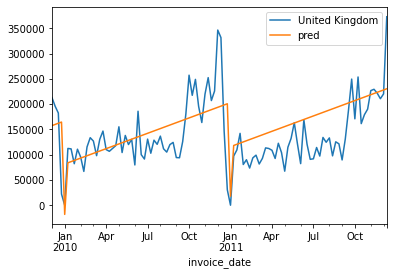

In [651]:
y[['United Kingdom', 'pred']].plot()

In [642]:
y.groupby(['year']).mean()

,United Kingdom,week_of_year,time_since_start,pred
year,,,,
2009,153303.725000,50.500000,10.5,183816.560528
2010,140388.517558,26.519231,206.5,135694.235169
2011,136194.594080,25.540000,563.5,138100.361285


# Create total 

In [80]:
# Compute revenue of order
df['Revenue'] = df['Quantity'] * df['Price']

In [81]:
# Extract useful data related features for analysing the data.
df['date'] = df['InvoiceDate'].dt.date
df['day_of_week'] = df['InvoiceDate'].dt.weekday
df['month'] = df['InvoiceDate'].dt.month
df['week_of_year'] = df['InvoiceDate'].dt.week
df['year_week'] = df['InvoiceDate'].dt.strftime('%Y-%W')
df['year_month'] = df['InvoiceDate'].dt.strftime('%Y-%m')

In [82]:
# Inspect dataframe after processing.
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancelled,revenue,date,day_of_week,month,week_of_year,year_week,year_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,False,83.4,2009-12-01,1,12,49,2009-48,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,False,81.0,2009-12-01,1,12,49,2009-48,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,False,81.0,2009-12-01,1,12,49,2009-48,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,False,100.8,2009-12-01,1,12,49,2009-48,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,False,30.0,2009-12-01,1,12,49,2009-48,2009-12


In [152]:
customer_orders = (
    df[is_not_cancelled]
    .groupby('Customer ID')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .to_frame()
)

In [153]:
customer_orders['Percentile'] =  (customer_orders['Quantity'].cumsum() / customer_orders['Quantity'].sum())

In [167]:
customer_orders[customer_orders['Quantity'] < 1000]

,Quantity,Percentile
Customer ID,,
13787,998,0.872422
13991,998,0.872515
16854,997,0.872608
13639,997,0.872701
16567,996,0.872794
...,...,...
17570,1,1.000000
14906,1,1.000000
14380,1,1.000000


In [147]:
customer_orders = customer_orders.sort_values(by='Percentile', ascending=False)

In [149]:
customer_orders.reset_index()

,Customer ID,Quantity,Percentile
0,14646,367833,1.000000e+00
1,13902,220600,9.656902e-01
2,13694,189205,9.451136e-01
3,18102,188340,9.274654e-01
4,14156,165992,9.098979e-01
...,...,...,...
5876,17570,1,4.663778e-07
5877,14906,1,3.731023e-07
5878,14380,1,2.798267e-07
5879,16047,1,1.865511e-07


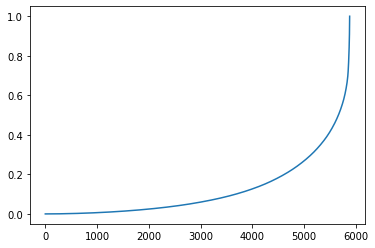

In [144]:

plt.plot( np.arange(0, len(customer_orders)), customer_orders['Percentile'].values)

# Create and visualise timeseries of the quantity of orders

## Global by year-week

/Users/km1308/.pyenv/versions/3.7.3/envs/udemy-ts/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


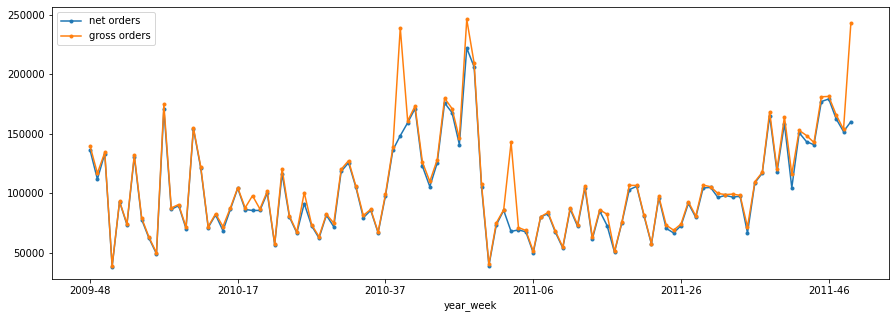

In [83]:
# Matplotlib 
fig, ax = plt.subplots(figsize=[15, 5])

# Net orders (i.e., orders minus cancellations)
timeseries = df.groupby(['year_week']).sum()['Quantity']
timeseries.plot(figsize=[15, 5], label='net orders', marker='.', ax=ax)

# Gross orders  
is_not_cancelled = ~df['is_cancelled']
timeseries = df[is_not_cancelled].groupby(['year_week']).sum()['Quantity']
timeseries.plot(figsize=[15, 5], label='gross orders', marker='.', ax=ax)

ax.legend()

/Users/km1308/.pyenv/versions/3.7.3/envs/udemy-ts/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


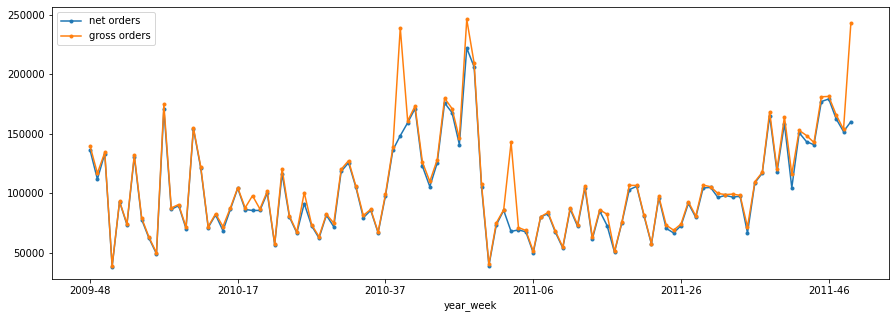

In [68]:
# Matplotlib 
fig, ax = plt.subplots(figsize=[15, 5])

# Net orders (i.e., orders minus cancellations)
timeseries = df.groupby(['year_week']).sum()['Quantity']
timeseries.plot(figsize=[15, 5], label='net orders', marker='.', ax=ax)

# Gross orders  
is_not_cancelled = ~df['is_cancelled']
timeseries = df[is_not_cancelled].groupby(['year_week']).sum()['Quantity']
timeseries.plot(figsize=[15, 5], label='gross orders', marker='.', ax=ax)

ax.legend()

## Country level

/Users/km1308/.pyenv/versions/3.7.3/envs/udemy-ts/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/km1308/.pyenv/versions/3.7.3/envs/udemy-ts/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/km1308/.pyenv/versions/3.7.3/envs/udemy-ts/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/km1308/.pyenv/versions/3.7.3/envs/udemy-ts/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/Users/km1308/.pyenv/versions/3.7.3/envs/udemy-ts/lib/python3.7/site-packages/pandas

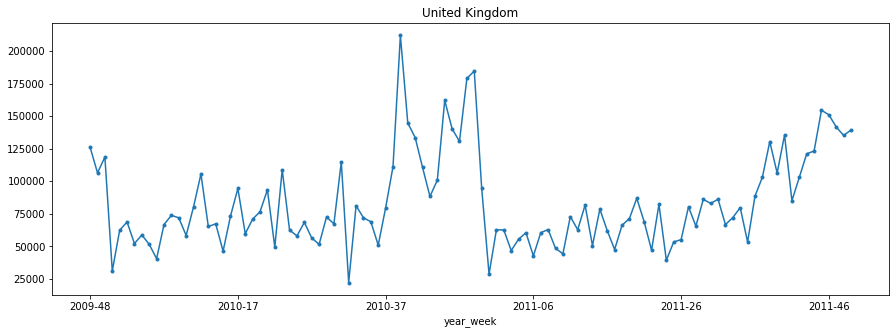

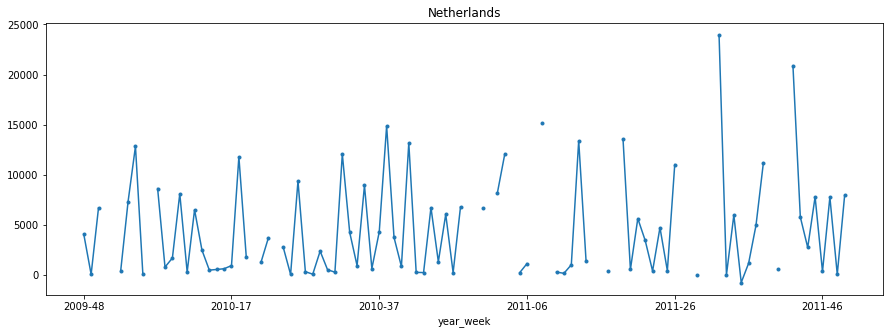

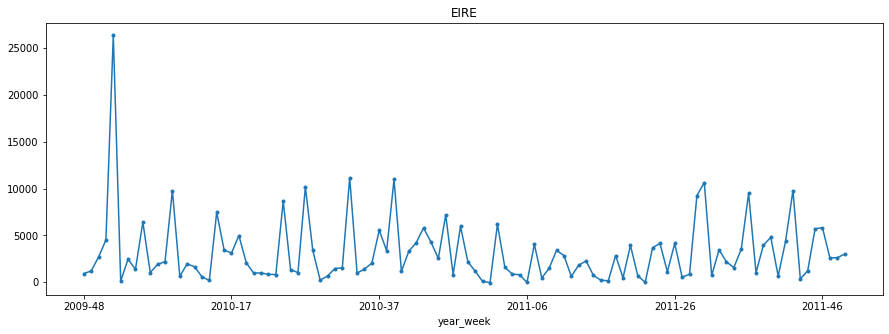

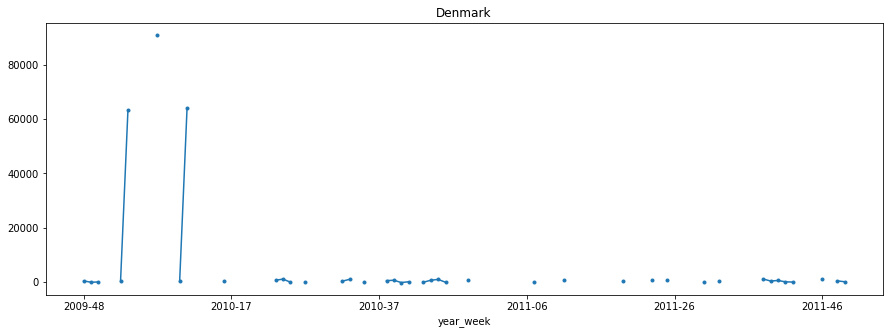

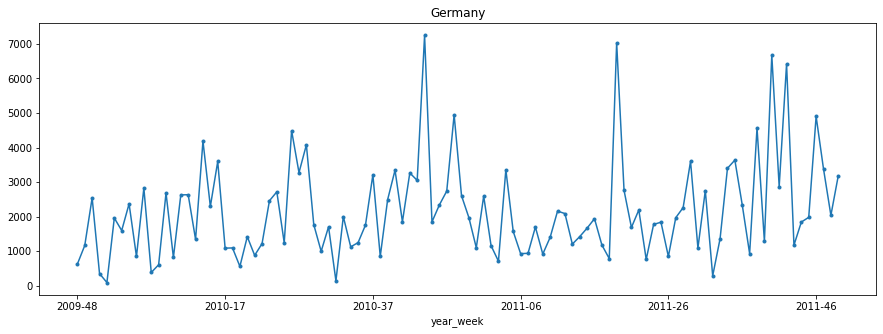

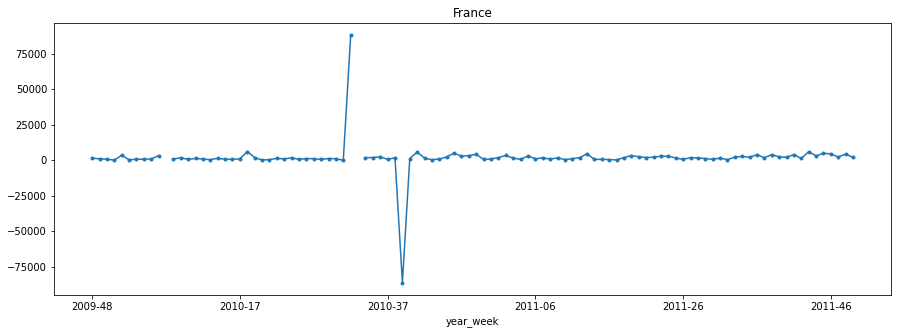

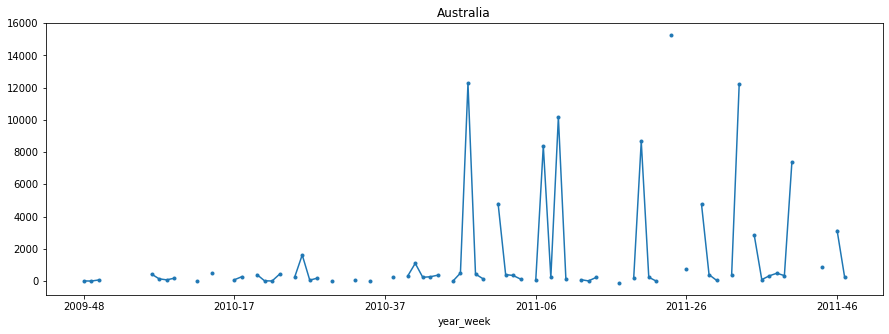

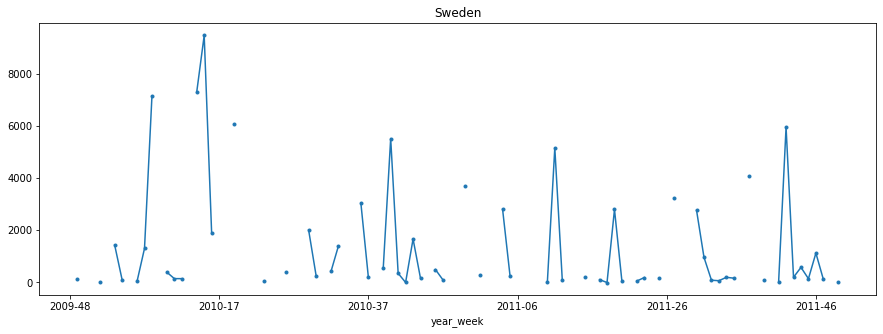

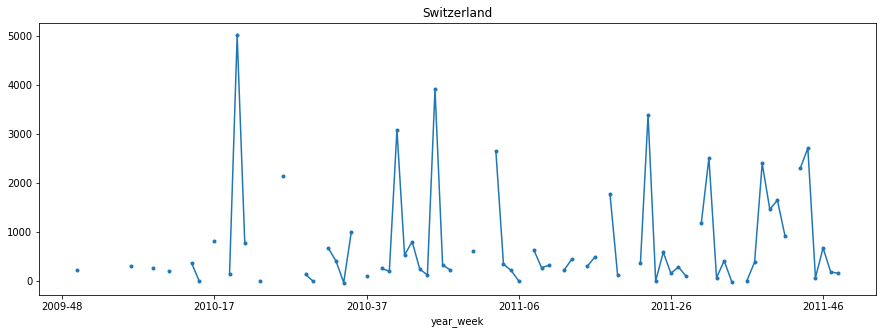

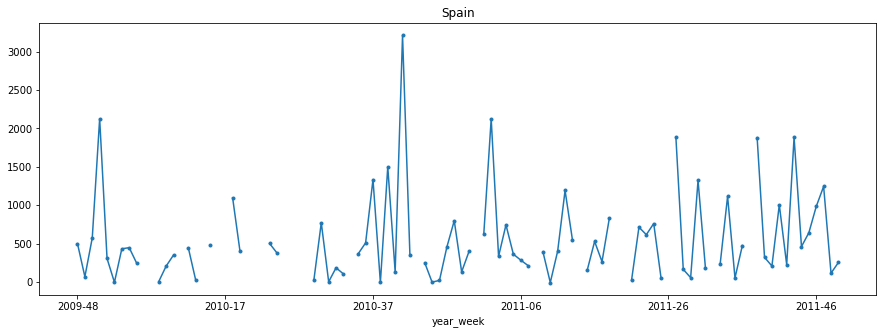

In [145]:
top_ten_countries = df.groupby(['Country']).sum()['Quantity'].sort_values(ascending=False).head(10).index

for country in top_ten_countries:
    # Matplotlib 
    fig, ax = plt.subplots(figsize=(3, 5))

    # Net orders (i.e., orders minus cancellations)
    timeseries = df.groupby(['Country', 'year_week']).sum()['Quantity'].unstack('Country')
    timeseries.loc[:, country].plot(figsize=[15, 5], label='net orders', marker='.', ax=ax)
    
    ax.set_title(country)

